# Coffee Lovers Unite!

If caffeine is one of the most popular drugs, then coffee is likely one of the most popular delivery systems for it. Aside from caffeine, people enjoy the wonderful variety of coffee-related drinks. Let’s do a rough investigation of the “market share” by two of the top coffee chains in the United States!  

World Population Review provides some great data on store locations and chain prevalence. Check out this page for the Starbucks Coffee locations in the United States (https://worldpopulationreview.com/state-rankings/starbucks-stores-by-state). Notice that this page only really gives the name of the state and the number of locations in that state.  

# Scrape the Location Counts  
1. Use the beautifulsoup library to scrape the data (from the link above) on state names and corresponding number of store locations, for the following chains:  
- Starbucks  
- Dunkin’ Donuts  

In [85]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from plotnine import *
import re

In [86]:
# Starbucks Data

# Send a GET request to the webpage
response = requests.get("https://worldpopulationreview.com/state-rankings/starbucks-stores-by-state")

# Parse the HTML content
soup = BeautifulSoup(response.content, "html.parser")  # Parses the HTML content into a structured format
# Allows us to search through the HTML and extract specific elements

# Find the main table
table = soup.find("table", class_="wpr-table")

# Initialize an empty list to store data for rows
rows = []

# Iterate over each row in the table to collect store data by state, skipping the header row
for row in table.find_all("tr")[1:]:
    # Extract the state name from the <th> tag in each row
    state = row.find("th").get_text(strip=True)
    
    # Find all data cells in the row
    cells = row.find_all("td")

    # Get the text for each year's store count from the cells, remove commas, and convert to integer, handling empty strings
    stores_2023 = int(cells[0].get_text(strip=True).replace(',', '')) if cells[0].get_text(strip=True) else None
    stores_2021 = int(cells[1].get_text(strip=True).replace(',', '')) if cells[1].get_text(strip=True) else None
    stores_2024 = int(cells[2].get_text(strip=True).replace(',', '')) if cells[2].get_text(strip=True) else None
    
    # ChatGPT 4o Recomedation: Append the extracted data for each state into the rows list as a dictionary
    rows.append({
        "state": state,
        "2023": stores_2023,
        "2021": stores_2021,
        "2024": stores_2024
    })

# Convert the list into a pandas DataFrame
starbucks = pd.DataFrame(rows)

# Many missing values for 2024, fill unknowns with 2023 since data is likely to be similar
starbucks['2024'] = starbucks['2024'].fillna(starbucks['2023'])

starbucks.head()

,state,2023,2021,2024
0,California,3080,2959.0,3117.0
1,Texas,1346,1215.0,1409.0
2,Florida,844,786.0,892.0
3,Washington,741,739.0,736.0
4,New York,692,643.0,715.0


In [87]:
# Dunkin' Donuts Data

# Send a GET request to the webpage
response = requests.get("https://worldpopulationreview.com/state-rankings/dunkin-donuts-by-state")

# Parse the HTML content
soup = BeautifulSoup(response.content, "html.parser")  # Parses the HTML content into a structured format
# Allows us to search through the HTML and extract specific elements

# Find the main table
table = soup.find("table", class_="wpr-table")

# Initialize an empty list to store data for rows
rows = []

# Iterate over each row in the table to collect store data by state, skipping the header row
for row in table.find_all("tr")[1:]:
    # Extract the state name from the <th> tag in each row
    state = row.find("th").get_text(strip=True)
    
    # Find all data cells in the row
    cells = row.find_all("td")

    # Get the text for each year's store count from the cells, remove commas, and convert to integer, handling empty strings
    stores_2024 = int(cells[0].get_text(strip=True).replace(',', '')) if cells[0].get_text(strip=True) else None
    stores_2023 = int(cells[1].get_text(strip=True).replace(',', '')) if cells[1].get_text(strip=True) else None
    
    # Append the extracted data for each state into the rows list as a dictionary
    rows.append({
        "state": state,
        "2024": stores_2024,
        "2023": stores_2023
    })

# Convert the list into a pandas DataFrame
dunkin = pd.DataFrame(rows)
dunkin.head()

,state,2024,2023
0,New York,1431,1414.0
1,Massachusetts,1042,1068.0
2,Florida,909,883.0
3,New Jersey,872,866.0
4,Illinois,711,692.0


2. Parse, merge and tidy your data. Think carefully about what the tidy version of this dataset is with multiple years represented on the website.

In [88]:
# Convert Starbucks Data to long format
starbucks_long = starbucks.melt(
    id_vars=["state"],
    value_vars=["2023", "2021", "2024"],
    var_name="year",
    value_name="store_count"
)
starbucks_long["location"] = "Starbucks" # Add a new column to indicate the location
# starbucks_long.head()

# Convert Dunkin' Donuts Data to long format
dunkin_long = dunkin.melt(
    id_vars=["state"],
    value_vars=["2024", "2023"],
    var_name="year",
    value_name="store_count"
)
dunkin_long["location"] = "Dunkin"  # Add a new column to indicate the location
# dunkin_long.head()

# Merge the two datasets into one
coffee = pd.concat([starbucks_long, dunkin_long], ignore_index=True)
coffee.head()

,state,year,store_count,location
0,California,2023,3080.0,Starbucks
1,Texas,2023,1346.0,Starbucks
2,Florida,2023,844.0,Starbucks
3,Washington,2023,741.0,Starbucks
4,New York,2023,692.0,Starbucks


# Supplemental Data  
3. Scrape the state names and populations from this wikipedia page: https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population
Merge these data with your coffee dataset.

In [89]:
# Send a GET request to the webpage
response = requests.get("https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population")

# Parse the HTML content
soup = BeautifulSoup(response.content, "html.parser")  # Parses the HTML content into a structured format

# Extract the table of interest
table = soup.find_all("table", class_ = "wikitable")[0] 

# Scrape population data from the table
rows = [] # Initialize an empty list to store data for rows

# Iterate over each row in the table, skipping the header row
for tr in table.find_all("tr")[1:]:
    cells = tr.find_all("td")
    
    # Ensure there are enough cells to avoid errors
    if len(cells) >= 4:
        # Get state names
        state = cells[2].get_text(strip=True)
        
        # Get the population value, remove commas, and convert to integer, handling empty strings
        population = int(cells[3].get_text(strip=True).replace(',', '')) if cells[2].get_text(strip=True) else None
        
        # Append data to the list as a dictionary
        rows.append({
            "state": state,
            "population": population  # Convert population to integer
        })

# Convert list to a pandas DataFrame
population = pd.DataFrame(rows)
# population.head()

# Merge the coffee dataset with the population dataset
coffee_pop = coffee.merge(population, on="state", how = "left")
coffee_pop.head()

,state,year,store_count,location,population
0,California,2023,3080.0,Starbucks,39538223
1,Texas,2023,1346.0,Starbucks,30145505
2,Florida,2023,844.0,Starbucks,21538187
3,Washington,2023,741.0,Starbucks,7705281
4,New York,2023,692.0,Starbucks,20201249


4. Find the revenue, stock price, or your financial metric of choice for each of the companies listed above (if you can find a website to scrape these from that’s great!…but it’s okay if you manually enter these). Merge these values into your big dataset. Note: these values may be repeated for each state.

In [90]:
# Create stock price Data
# I will use the Starbucks stock price for January 1 of each year
# Dunkin is now privately owned, but its most recent stock price is $106.48

data = [
    {"year": 2021, "location": "Starbucks", "stock_price": 107.66},
    {"year": 2022, "location": "Starbucks", "stock_price": 116.47},
    {"year": 2023, "location": "Starbucks", "stock_price": 100.56},
    {"year": 2024, "location": "Starbucks", "stock_price": 95.45},
    {"year": 2023, "location": "Dunkin", "stock_price": 106.48},
    {"year": 2024, "location": "Dunkin", "stock_price": 106.48}
]

stock_prices = pd.DataFrame(data)

# Prepare data for merge
coffee_pop.dropna(subset=["year"], inplace=True)
coffee_pop["year"] = coffee_pop["year"].astype(int)
stock_prices["year"] = stock_prices["year"].astype(int) # make sure year is the same type for both datasets

# Merge the coffee dataset with the stock prices dataset
coffee_stock = pd.merge(coffee_pop, stock_prices, on=["location", "year"], how="left")
coffee_stock.head()

,state,year,store_count,location,population,stock_price
0,California,2023,3080.0,Starbucks,39538223,100.56
1,Texas,2023,1346.0,Starbucks,30145505,100.56
2,Florida,2023,844.0,Starbucks,21538187,100.56
3,Washington,2023,741.0,Starbucks,7705281,100.56
4,New York,2023,692.0,Starbucks,20201249,100.56


5. Create a region variable in your dataset according to the scheme on this wikipedia page: Northeast, Midwest, South, West. You do not need to scrape this information.
https://en.wikipedia.org/wiki/List_of_regions_of_the_United_States

In [91]:
# Define the state to region mapping based on U.S. Census regions and divisions
state_region = {
    # Northeast
    'Connecticut': 'Northeast', 'Maine': 'Northeast', 'Massachusetts': 'Northeast',
    'New Hampshire': 'Northeast', 'Rhode Island': 'Northeast', 'Vermont': 'Northeast',
    'New Jersey': 'Northeast', 'New York': 'Northeast', 'Pennsylvania': 'Northeast',

    # Midwest
    'Illinois': 'Midwest', 'Indiana': 'Midwest', 'Michigan': 'Midwest', 
    'Ohio': 'Midwest', 'Wisconsin': 'Midwest',
    'Iowa': 'Midwest', 'Kansas': 'Midwest', 'Minnesota': 'Midwest', 
    'Missouri': 'Midwest', 'Nebraska': 'Midwest', 'North Dakota': 'Midwest', 
    'South Dakota': 'Midwest',

    # South
    'Delaware': 'South', 'Florida': 'South', 'Georgia': 'South', 'Maryland': 'South', 
    'North Carolina': 'South', 'South Carolina': 'South', 'Virginia': 'South', 
    'West Virginia': 'South', 'Washington, D.C.': 'South',
    'Alabama': 'South', 'Kentucky': 'South', 'Mississippi': 'South', 'Tennessee': 'South',
    'Arkansas': 'South', 'Louisiana': 'South', 'Oklahoma': 'South', 'Texas': 'South',

    # West
    'Arizona': 'West', 'Colorado': 'West', 'Idaho': 'West', 'Montana': 'West', 
    'Nevada': 'West', 'New Mexico': 'West', 'Utah': 'West', 'Wyoming': 'West',
    'Alaska': 'West', 'California': 'West', 'Hawaii': 'West', 
    'Oregon': 'West', 'Washington': 'West'
}

# Add the 'region' column to coffee_stock by mapping the 'state' column
coffee_stock['region'] = coffee_stock['state'].map(state_region)
coffee_stock.head()


,state,year,store_count,location,population,stock_price,region
0,California,2023,3080.0,Starbucks,39538223,100.56,West
1,Texas,2023,1346.0,Starbucks,30145505,100.56,South
2,Florida,2023,844.0,Starbucks,21538187,100.56,South
3,Washington,2023,741.0,Starbucks,7705281,100.56,West
4,New York,2023,692.0,Starbucks,20201249,100.56,Northeast


# Analyze
6. Assess and comment on the prevalence of each chain. Some questions to consider (you don’t need to answer all of these and you may come up with your own):  
- Are some of these chains more prevalent in certain states than others? Possibly despite having less stores overall? Same questions for regions instead of states.  
- How does your chosen financial metric change by state and region for each chain? For example, having 5 stores in California is very different from having 5 stores in Wyoming.  
- Does the distribution of each chain’s stores match population distribution, by both state/region?  
- Do the financial data match what you’d expect based on the number and locations of the stores? Why or why not?  

## Comparing Regional Presence of Starbucks and Dunkin'

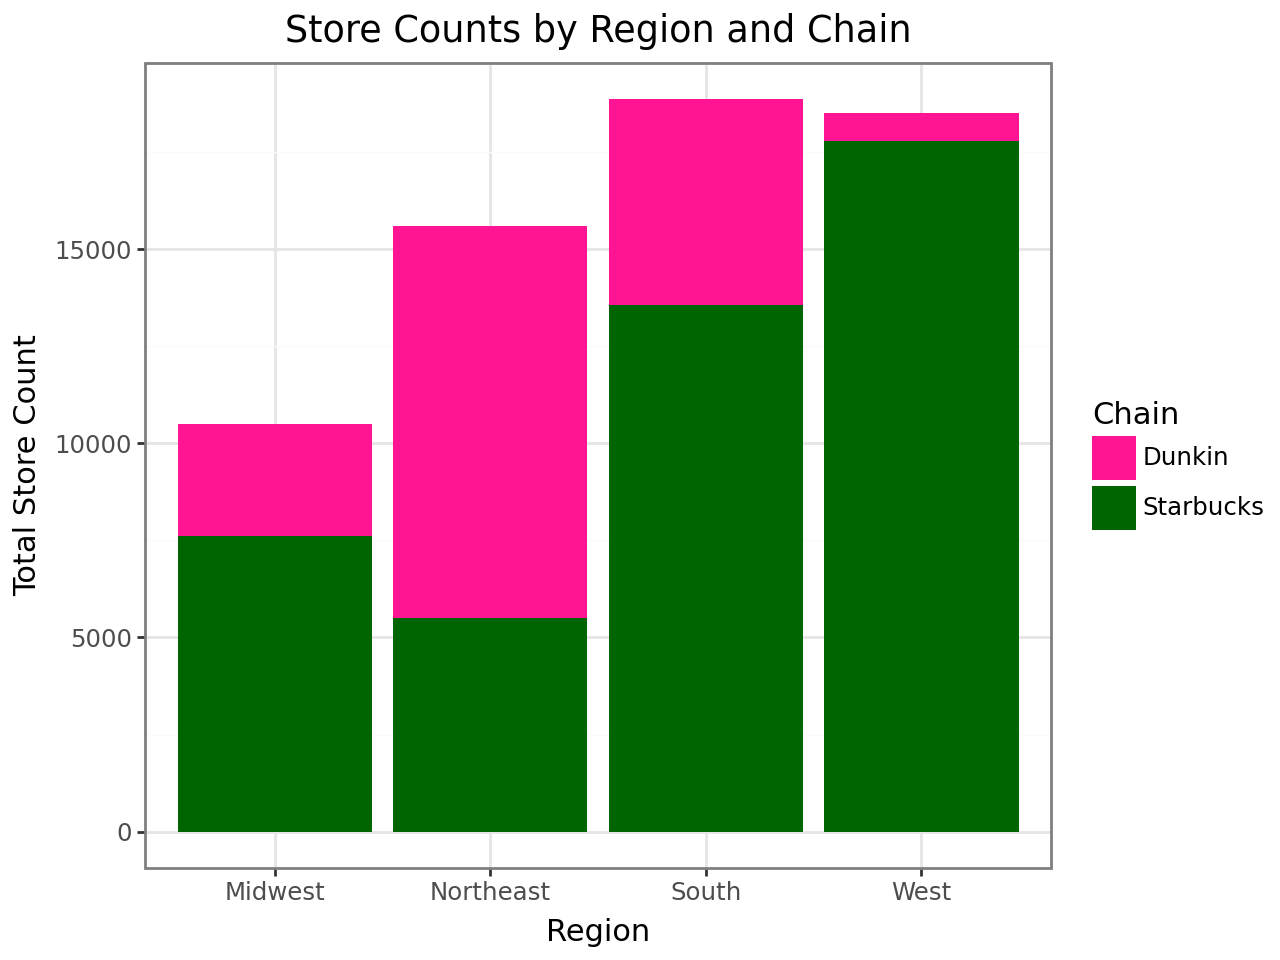

In [92]:
# Group the data by region and location, and calculate the total store count
region_data = coffee_stock.groupby(['region', 'location'])['store_count'].sum().reset_index()

(ggplot(region_data, aes(x='region', y='store_count', fill='location')) +
    geom_bar(stat='identity', position='stack') +
    labs(title='Store Counts by Region and Chain',
           x='Region',
           y='Total Store Count',
           fill='Chain') +
    scale_fill_manual({
    'Starbucks': 'darkgreen',
    'Dunkin': 'deeppink'
}) +
    theme_bw()
)

The bar chart reveals that Starbucks has a widespread presence across the U.S., with especially high numbers in the West and South. Dunkin' has a much smaller presence in the West, where Starbucks dominates almost entirely. However, Dunkin' is particularly popular in the Northeast, where it actually has more stores than Starbucks. Although Starbucks generally has more stores across all regions, Dunkin' remains more prominent in the Northeast. This suggests that while Starbucks is more uniformly distributed across the country, Dunkin' remains especially influential in the Northeast, despite having fewer stores overall.

## Comparing Stock Price Trends of Starbucks and Dunkin' Donuts

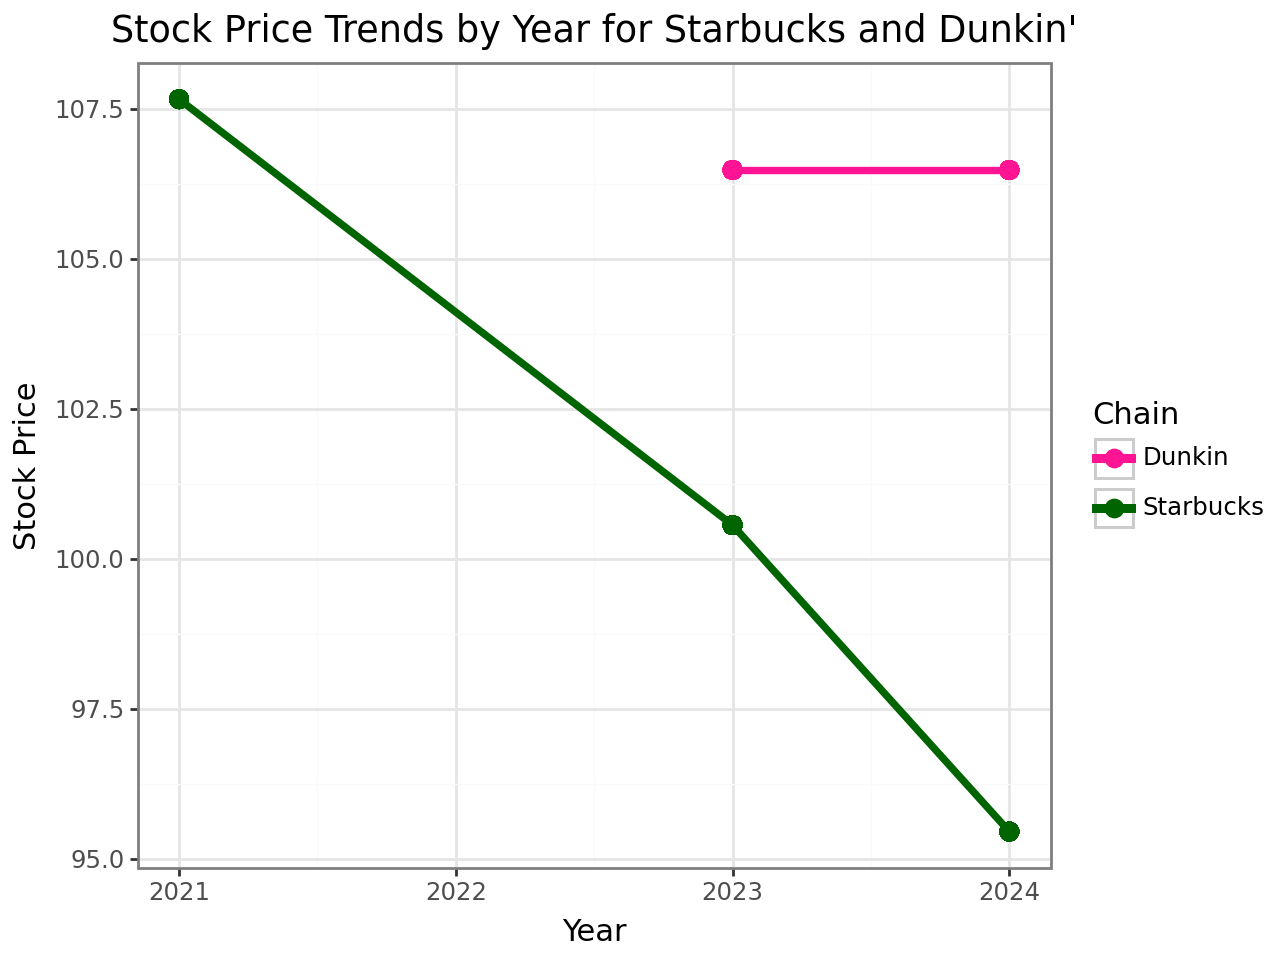

In [93]:
(ggplot(coffee_stock, aes(x='year', y='stock_price', color='location', group='location')) +
    geom_line(size=1.5)  +
    geom_point(size=3) +
    scale_color_manual({
    'Starbucks': 'darkgreen',
    'Dunkin': 'deeppink'
}) +
    labs(title='Stock Price Trends by Year for Starbucks and Dunkin\'',
        x='Year',
        y='Stock Price',
        color='Chain') +
    theme_bw()
)


The line plot shows stock price trends for Starbucks and Dunkin' over recent years, though there are limitations in the data. For Starbucks, I used stock prices from January 1st each year, giving an annual view of its performance. Dunkin', now privately owned, does not have any recent public stock prices, so the last available price from 2020 ($106.48) was used for both 2023 and 2024.

The plot reveals a steady downward trend for Starbucks, with its stock price declining from 2021 to 2024. In contrast, Dunkin's price remains flat due to the lack of updated data, yet it stands higher than Starbucks' recent values—even close to Starbucks’ highest point in 2021. This suggests that while Starbucks has experienced some setbacks, Dunkin's last known public value was relatively strong by comparison, though we lack current data to confirm its trend.

## Relationship Between Population and Store Count by Chain

c:\Users\bri_r\AppData\Local\Programs\Python\Python313\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 2 rows containing missing values.


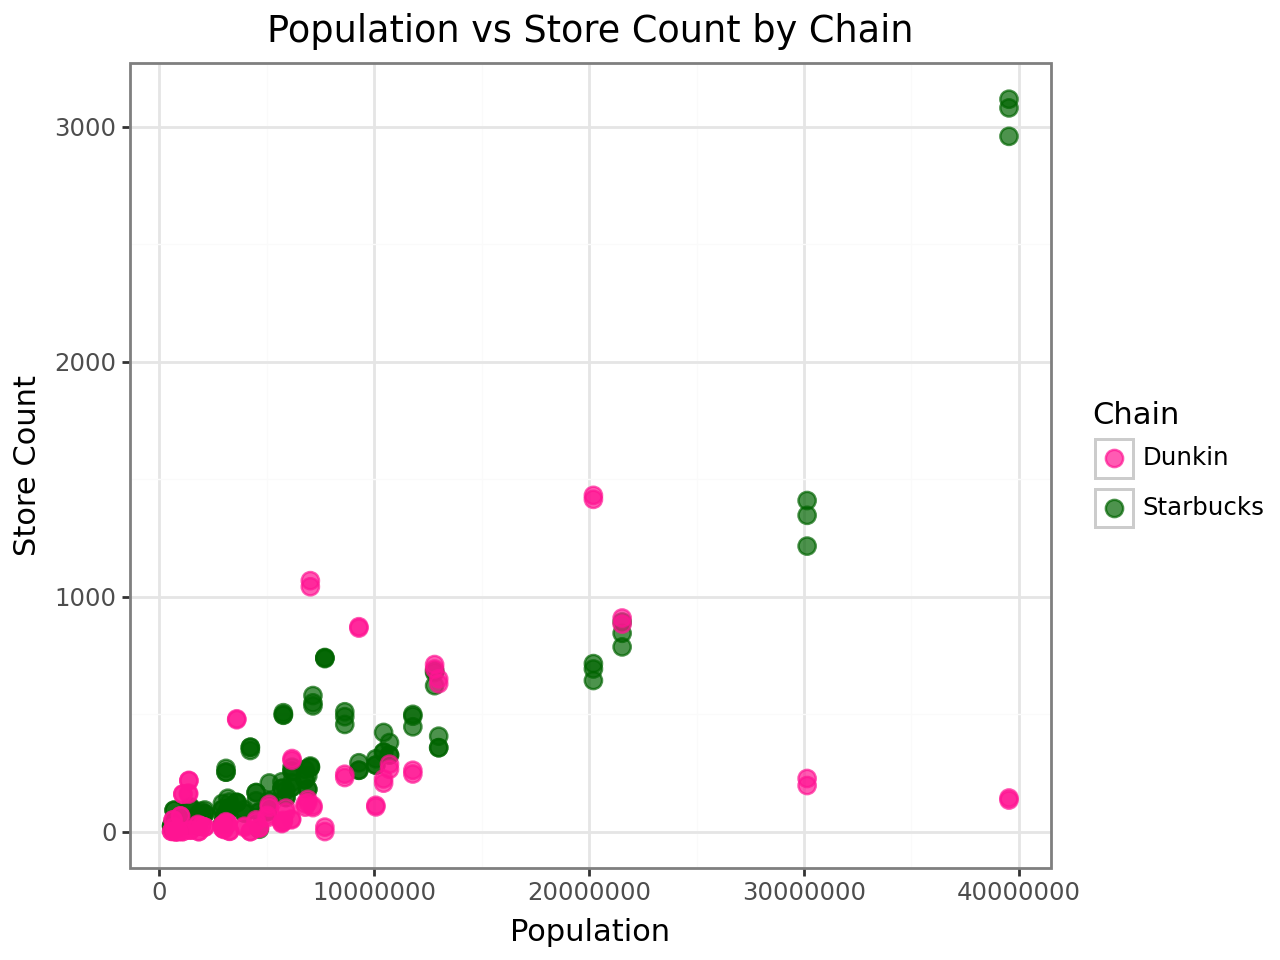

In [94]:
(ggplot(coffee_stock, aes(x='population', y='store_count', color='location')) +
    geom_point(size=3, alpha=0.7) +
    labs(title='Population vs Store Count by Chain',
        x='Population',
        y='Store Count',
        color='Chain') +
    scale_color_manual({
    'Starbucks': 'darkgreen',
    'Dunkin': 'deeppink'}) +
    theme_bw()
)

This scatter plot shows the relationship between state population and the number of Dunkin' and Starbucks stores. Each dot represents a state, with pink for Dunkin' and green for Starbucks. Generally, as state population increases, so does the store count, especially for Starbucks, which has a significant presence in the most populated states, visible in the upper right corner of the plot.

Starbucks has more stores across most population sizes compared to Dunkin'. However, for states with smaller populations, both chains have a similar number of stores, as seen in the cluster of points on the lower left. This suggests that while Starbucks focuses heavily on high-population areas, Dunkin' maintains a broader spread, keeping a steady presence even in less populated states. Starbucks appears to have a larger presence overall while Dunkin' is more evenly distributed across population sizes.

## Yearly Comparison of Store Counts by Chain

c:\Users\bri_r\AppData\Local\Programs\Python\Python313\Lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_boxplot : Removed 1 rows containing non-finite values.


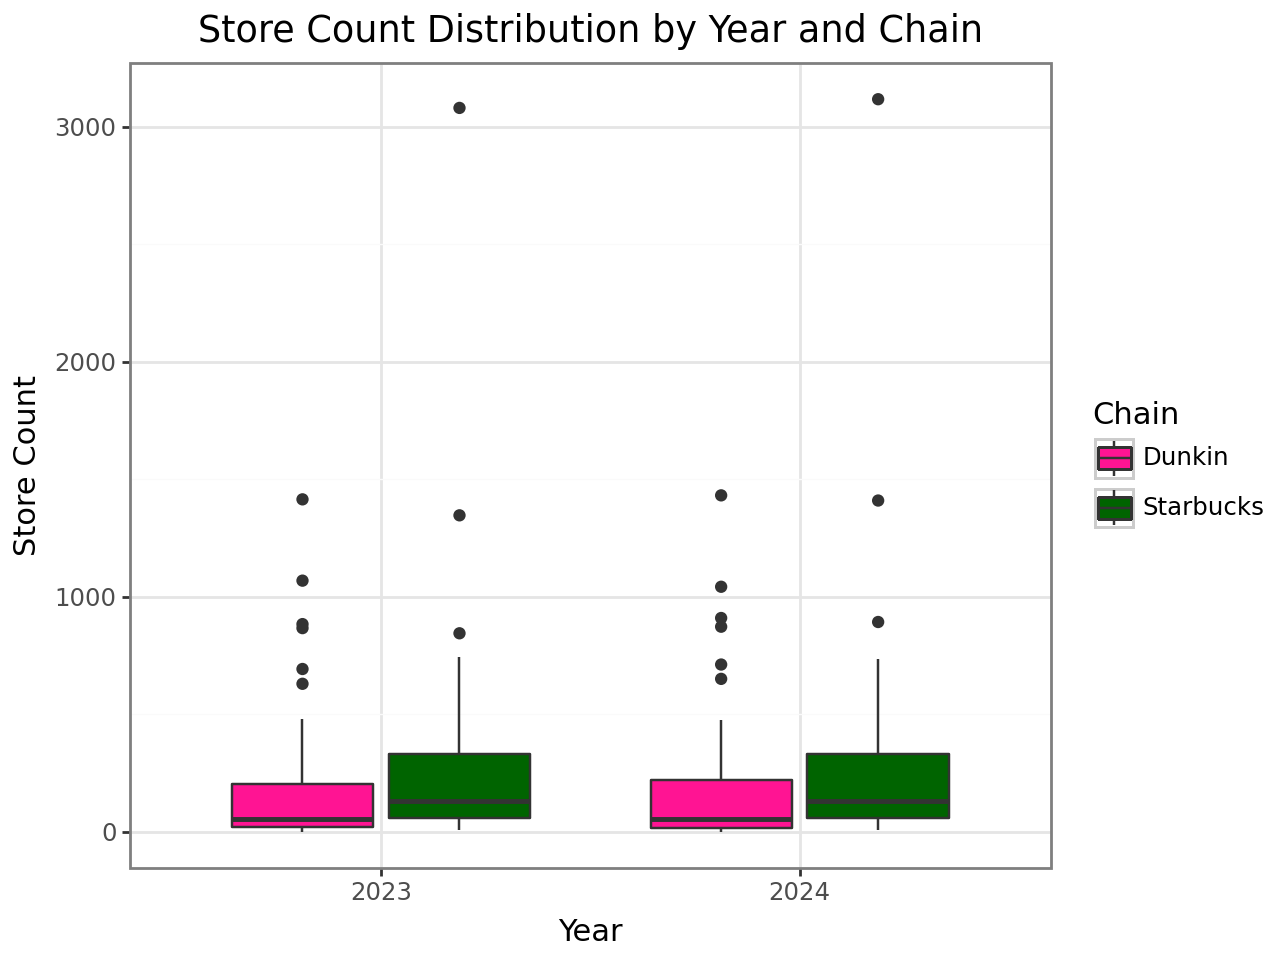

In [95]:
# Filter data to only look at 2023 and 2024
filtered_data = coffee_stock[coffee_stock['year'].isin([2023, 2024])]

(ggplot(filtered_data, aes(x='factor(year)', y='store_count', fill='location')) +
    geom_boxplot() +
    scale_fill_manual(values={'Starbucks': 'darkgreen',
                              'Dunkin': 'deeppink'}) +
    labs(title="Store Count Distribution by Year and Chain",
        x="Year",
        y="Store Count",
        fill="Chain") +
        theme_bw()
)

This facet boxplot displays the distribution of store counts for Dunkin' and Starbucks in 2023 and 2024. In the plot, each box represents the spread of store counts across states for the respective chain and year. The median store count for Starbucks is considerably higher than Dunkin' in both years, as shown by the position of the boxes. Additionally, Starbucks has a wider range of store counts, with several states having store counts that reach above 3,000, especially in 2024. Dunkin's store count distribution is more concentrated, with most states having fewer than 1,000 stores, indicated by the compact box and shorter whiskers.

# Automate  
Convert your code for Exercises 1-3 above to a function that takes a single argument: the URL. This function should:  

- Scrape the information on state names and corresponding number of store locations on the webpage specified (assume the page has a table in the same form and placement as the ones you scraped above)  
- Extract the name of the company from either the URL specified or the webpage (assume the URL will have the same format as the ones used above)  
- Return a clean, organized and tidy dataset. Find a page other than Starbucks and Dunkin’ Donuts to test this on to confirm that it works. It’s fine if this is not related to coffee.  

In [96]:
def scrape_store_data(url):
    """
    Scrapes state and store count data from a specified URL.

    Parameter
    ---------
    url : str
        The URL of the webpage containing the store location data in a table format.

    Returns
    ---------
    pd.DataFrame
        A DataFrame with two columns - 'state' and 'store_count', representing each state's name and the number of stores.
    """
    
    # Send a GET request to the webpage
    response = requests.get(url)

    # Parse the HTML content
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Find the table with the store locations
    table = soup.find('table')
    
    # Extract the company name from the URL
    company_name = url.split('/')[-1]
    
    # Define headers as 'state' and 'store_count'
    headers = ['state', 'store_count']
    
    rows = []
    for row in table.find_all('tr')[1:]:  # Skip header row
        cells = row.find('th').text.strip()  # Get state name from <th>
        store_count = int(row.find('td').text.strip().replace(',', '')) # Get store count from <td> and convert to integer
        
        # Append row as a dictionary
        rows.append({
            'state': cells,
            'store_count': store_count
        })
    
    # Create DataFrame with the specified column names
    df = pd.DataFrame(rows, columns=headers)
    
    return df


In [97]:
# Test the function with a different URL
url = "https://worldpopulationreview.com/state-rankings/walmart-stores-by-state"
data = scrape_store_data(url)
data.head()

,state,store_count
0,Texas,517
1,Florida,341
2,California,280
3,North Carolina,192
4,Georgia,189


# Appendix and References
- Convert number into integer: https://www.w3schools.com/python/ref_func_int.asp
- Starbuck stock price: https://finance.yahoo.com/quote/SBUX/history/?frequency=1mo&period1=1609459200&period2=1704067200
- Dunkin' Donuts stock price: https://www.investing.com/equities/dunkin-brands-group-chart
- Walmart Store Data: https://worldpopulationreview.com/state-rankings/walmart-stores-by-state

Generative AI Statement:  
In this lab, ChatGPT 4o was helpful for several key tasks. It helped in drafting the final function to scrape data from different websites, making it adaptable for various formats. It also made the process of mapping states to regions more efficient, ensuring accuracy with U.S. Census regions. Additionally, ChatGPT 4o assisted with debugging by explaining error messages and improving code organization. This guidance helped create a cleaner and more efficient code structure, making the data scraping process smoother and more reliable.